# Рекомендация тарифов

В вашем распоряжении данные о поведении клиентов, которые уже перешли на эти тарифы (из проекта курса «Статистический анализ данных»). Нужно построить модель для задачи классификации, которая выберет подходящий тариф. Предобработка данных не понадобится — вы её уже сделали.

Постройте модель с максимально большим значением *accuracy*. Чтобы сдать проект успешно, нужно довести долю правильных ответов по крайней мере до 0.75. Проверьте *accuracy* на тестовой выборке самостоятельно.

## 1. Откройте и изучите файл

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.interpolate import make_interp_spline, BSpline
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import numpy as np

data = pd.read_csv('/datasets/users_behavior.csv')


In [2]:
data.head()


,calls,minutes,messages,mb_used,is_ultra
0,40.0,311.90,83.0,19915.42,0
1,85.0,516.75,56.0,22696.96,0
2,77.0,467.66,86.0,21060.45,0
3,106.0,745.53,81.0,8437.39,1
4,66.0,418.74,1.0,14502.75,0


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
calls       3214 non-null float64
minutes     3214 non-null float64
messages    3214 non-null float64
mb_used     3214 non-null float64
is_ultra    3214 non-null int64
dtypes: float64(4), int64(1)
memory usage: 125.7 KB


## 2. Разбейте данные на выборки

In [4]:
train, test = train_test_split(data, test_size = 0.2, random_state = 12345)
train, valid = train_test_split(train, test_size = 0.25, random_state = 12345)
#Разбиваем наш датасэт на тренировочную, валидационную и тестовую выборки. 60/20/20

In [5]:
train_features = train.drop(columns = ['is_ultra'])
train_target = train['is_ultra']
valid_features = valid.drop(columns = ['is_ultra'])
valid_target = valid['is_ultra']
test_features = test.drop(columns = ['is_ultra'])
test_target = test['is_ultra']

## 3. Исследуйте модели

#Наша задача представляет собой задачу классификации. Есть 3 модели, ее решающие: DecisionTreeClassifier, RandomForestClassifier и LogisticRegression. Поочереди обучим их, перебирая гиперпараметры и выберем лучшую по метрике accuracy.

# DecisionTreeClassifier

In [6]:
iterations_number = []
valid_iterations = []
train_iterations = []
for i in range(3, 9):
    iterations_number.append(i)
    model_tree = DecisionTreeClassifier(max_depth = i, random_state = 12345)
    model_tree.fit(train_features, train_target)
    train_predictions_tree = model_tree.predict(train_features)
    valid_predictions_tree = model_tree.predict(valid_features)
    train_accuracy_tree = accuracy_score(train_target, train_predictions_tree)
    train_iterations.append(train_accuracy_tree)
    valid_accuracy_tree = accuracy_score(valid_target, valid_predictions_tree)
    valid_iterations.append(valid_accuracy_tree)
    print('Точность модели на тренировочной выборке с max_depth =', str(i),  train_accuracy_tree)
    print('Точность модели на валидационной выборке с max_depth =', str(i), valid_accuracy_tree)

Точность модели на тренировочной выборке с max_depth = 3 0.8117219917012448
Точность модели на валидационной выборке с max_depth = 3 0.7651632970451011
Точность модели на тренировочной выборке с max_depth = 4 0.8205394190871369
Точность модели на валидационной выборке с max_depth = 4 0.7636080870917574
Точность модели на тренировочной выборке с max_depth = 5 0.8272821576763485
Точность модели на валидационной выборке с max_depth = 5 0.7589424572317263
Точность модели на тренировочной выборке с max_depth = 6 0.8335062240663901
Точность модели на валидационной выборке с max_depth = 6 0.7573872472783826
Точность модели на тренировочной выборке с max_depth = 7 0.8506224066390041
Точность модели на валидационной выборке с max_depth = 7 0.7744945567651633
Точность модели на тренировочной выборке с max_depth = 8 0.8661825726141079
Точность модели на валидационной выборке с max_depth = 8 0.7667185069984448


In [7]:
d = {'max_depth': iterations_number, 'train_iteration': train_iterations, 'valid_iteration' : valid_iterations}
data_tree = pd.DataFrame(data=d)


In [8]:
data_tree_melted = data_tree.melt('max_depth', var_name = 'iterations', value_name = 'vals')

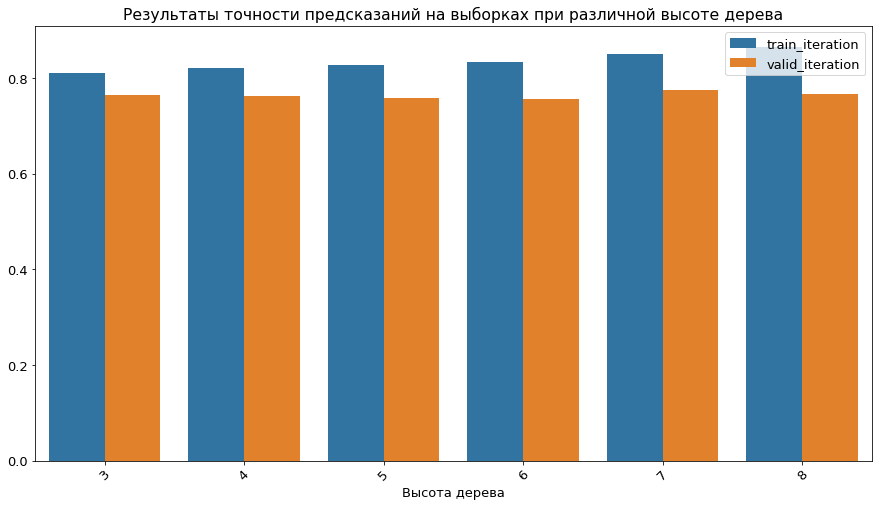

In [9]:
plt.rcParams.update({'font.size': 13})
plt.figure(figsize = (15,8))
ax = sns.barplot(x='max_depth', y= 'vals', hue = 'iterations', data=data_tree_melted)
plt.title('Результаты точности предсказаний на выборках при различной высоте дерева')
plt.xlabel('Высота дерева')
plt.ylabel('')
plt.xticks(rotation = 45)
plt.legend(loc = 'best')
plt.show()

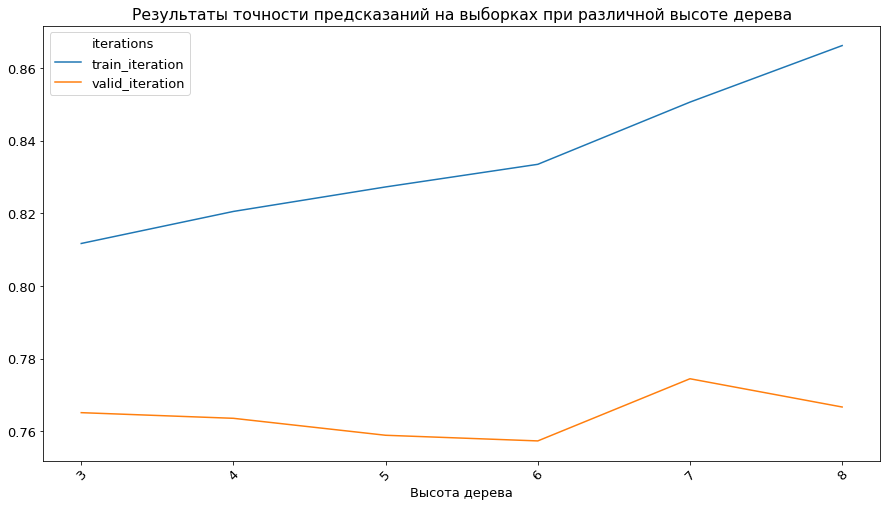

In [10]:
plt.rcParams.update({'font.size': 13})
plt.figure(figsize = (15,8))
ax = sns.lineplot(x='max_depth', y= 'vals', hue = 'iterations', data=data_tree_melted)
plt.title('Результаты точности предсказаний на выборках при различной высоте дерева')
plt.xlabel('Высота дерева')
plt.ylabel('')
plt.xticks(rotation = 45)
plt.legend(loc = 'best')
plt.show()

#В ТЗ есть цель, чтобы метрика точности была не ниже 0.75 --> все деревья проходят, но с глубиной 3 лучше всех, так и не будем чрезмерно усложнять модель, выберем первое дерево, затем проверим еще на тестовой выборке. 
Также можно сделать вывод по тому, что точность моделей на тренировочных и валидационных выборках отличаются не столь сильно, то переобучение отсутствует.

# RandomForestClassifier

In [11]:
iterations_number = []
valid_iterations = []
train_iterations = []
for i in range(3, 9):
    for j in range(3,20,2):
        for r in range(1,20,2):
                iterations_number.append((i,j,r))
                model_forest = RandomForestClassifier(max_depth = i, n_estimators = j, min_samples_leaf = r,  random_state = 12345)
                model_forest.fit(train_features, train_target)
                train_predictions_forest = model_forest.predict(train_features)
                valid_predictions_forest = model_forest.predict(valid_features)
                train_accuracy_forest = accuracy_score(train_target, train_predictions_forest)
                train_iterations.append(train_accuracy_forest)
                valid_accuracy_forest = accuracy_score(valid_target, valid_predictions_forest)
                valid_iterations.append(valid_accuracy_forest)
                print('Точность модели с max_depth =', str(i),  'количеством деревьев =', str(j), 'минимальный размер листа', str(r), valid_accuracy_forest)

Точность модели с max_depth = 3 количеством деревьев = 3 минимальный размер листа 1 0.76049766718507
Точность модели с max_depth = 3 количеством деревьев = 3 минимальный размер листа 3 0.76049766718507
Точность модели с max_depth = 3 количеством деревьев = 3 минимальный размер листа 5 0.76049766718507
Точность модели с max_depth = 3 количеством деревьев = 3 минимальный размер листа 7 0.7589424572317263
Точность модели с max_depth = 3 количеством деревьев = 3 минимальный размер листа 9 0.7589424572317263
Точность модели с max_depth = 3 количеством деревьев = 3 минимальный размер листа 11 0.7589424572317263
Точность модели с max_depth = 3 количеством деревьев = 3 минимальный размер листа 13 0.7620528771384136
Точность модели с max_depth = 3 количеством деревьев = 3 минимальный размер листа 15 0.7620528771384136
Точность модели с max_depth = 3 количеством деревьев = 3 минимальный размер листа 17 0.7620528771384136
Точность модели с max_depth = 3 количеством деревьев = 3 минимальный размер

In [12]:
d = {'max_depth': iterations_number, 'train_iteration': train_iterations, 'valid_iteration' : valid_iterations}
data_forest = pd.DataFrame(data=d)
data_forest['diff'] = data_forest['train_iteration'] - data_forest['valid_iteration']
max_diff = data_forest['diff'].max()
max_diff

0.08339329388305594

#Максимальная разница 8.34%, думаю, что переобучение отсутствует.

In [13]:
data_forest.iloc[data_forest['valid_iteration'].idxmax()]

max_depth          (8, 3, 7)
train_iteration      0.83973
valid_iteration     0.797823
diff               0.0419076
Name: 453, dtype: object

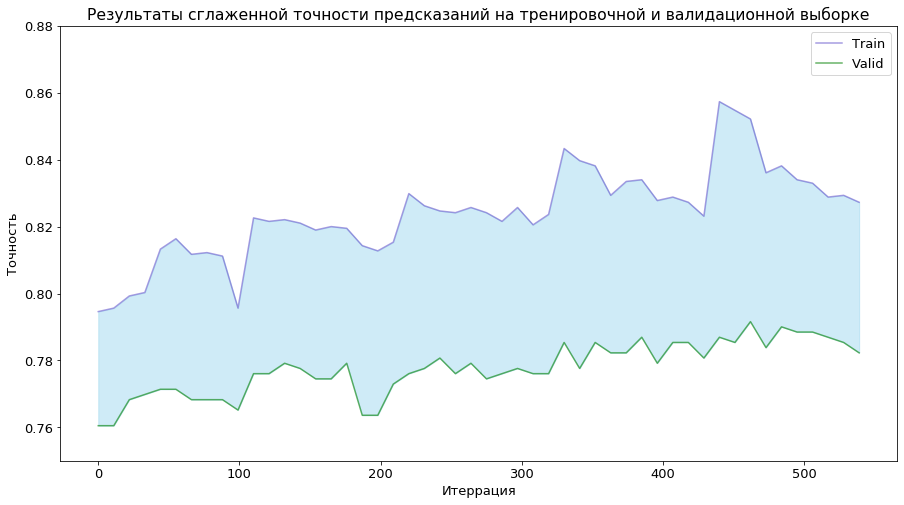

In [14]:
plt.rcParams.update({'font.size': 13})
plt.figure(figsize = (15,8))
xnew = np.linspace(data_forest.index.min(), data_forest.index.max(), 50)
spl = make_interp_spline(data_forest.index, data_forest['train_iteration'], k = 3)
y_smooth_train = spl(xnew)
spl = make_interp_spline(data_forest.index, data_forest['valid_iteration'], k = 3)
y_smooth_valid = spl(xnew)
plt.fill_between(xnew, y_smooth_train, y_smooth_valid,  color="skyblue", alpha=0.4)
ax1 =  plt.plot(xnew, y_smooth_train, color="Slateblue", alpha=0.6)
ax2 = plt.plot(xnew, y_smooth_valid, color="Green", alpha=0.6)
plt.ylim(0.75, 0.88)
plt.legend(labels = ['Train', 'Valid'])
plt.title('Результаты сглаженной точности предсказаний на тренировочной и валидационной выборке')
plt.xlabel('Итеррация')
plt.ylabel('Точность')
plt.show()

#Получили, что наивысшая точность у модели случайного леса с максимальной глубиной дерева равной 8,количеством деревьев равным 3 и минимальным размером листа 7. Ну и что вне зависимости от гиперпараметров модели точность предсказаний на тренеровочном сэте всегда выше, но переобучения все же не наблюдается.


# LogisticRegression

In [15]:
model_logistic = LogisticRegression(random_state = 12345, solver='lbfgs', max_iter=1000)
model_logistic.fit(train_features, train_target)
valid_predictions_logistic = model_logistic.predict(valid_features)
accuracy_logistic = accuracy_score(valid_target, valid_predictions_logistic)
print('Точность модели логистической регресии', accuracy_logistic)

Точность модели логистической регресии 0.7262830482115086


#Точность логистической модели ниже заявленного минимума. Гиперпараметров там нет, значит не будем ее применять к тетовой выборке.

## 4. Проверьте модель на тестовой выборке

In [16]:
model_tree = DecisionTreeClassifier(max_depth = 3, random_state = 12345)
model_tree.fit(train_features, train_target)
test_predictions_tree = model_tree.predict(test_features)
accuracy_tree = accuracy_score(test_target, test_predictions_tree)
print(accuracy_tree)

0.7869362363919129


#Снова обучили модель решающего дерева, но уже с наиболее удачным значением гиперпараметра, видим, что метрика снизилась, но по-прежнему остается выше требуемого минимума. 

In [17]:
model_forest = RandomForestClassifier(max_depth = 8, n_estimators =3, min_samples_leaf = 7,random_state = 12345)
model_forest.fit(train_features, train_target)
test_predictions_forest = model_forest.predict(test_features)
accuracy_forest = accuracy_score(test_target, test_predictions_forest)
print(accuracy_forest)

0.7916018662519441


#Тоже самое проделали с моделью случайного леса, таже картина.

## 5. (бонус) Проверьте модели на адекватность

#Проверим сбалансированность классов в тестовой выборке.

In [18]:
test['is_ultra'].mean()

0.3048211508553655

#Исходя из этих значений констатная модель выдавала бы accuracy около 0,696 если бы был присвоен 0 всей выборке. Обе модели, которые успешно прошли проверку на тестовой выборке, имею accuracy выше этого значения, что подтверждает их адекватность. 

# Выводы

#Выполняя задачу классификации нужно применить несколько моделей, в которых стоит перебрать значения гиперпараметров. Провести валидвцию - выбрать модели с наилучшими метриками и дальше их испытвать на выборке тестирования. В нашем случае 2 из 3 моделей выполнили задачу успешно: провели классификацию клиентов и превысили пороговое значение accuracy из ТЗ.

## Чек-лист готовности проекта

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x] Jupyter Notebook открыт
- [x] Весь код исполняется без ошибок
- [x] Ячейки с кодом расположены в порядке исполнения
- [x] Выполнено задание 1: данные загружены и изучены
- [x] Выполнено задание 2: данные разбиты на три выборки
- [x] Выполнено задание 3: проведено исследование моделей
    - [x] Рассмотрено больше одной модели
    - [x] Рассмотрено хотя бы 3 значения гипепараметров для какой-нибудь модели
    - [x] Написаны выводы по результатам исследования
- [x] Выполнено задание 3: Проведено тестирование
- [x] Удалось достичь accuracy не меньше 0.75
